In [1]:
import torch
import datasets

from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0")

In [2]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, lr_scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            loss_accum += loss_value.item()
            
        ave_loss = loss_accum / i_step
        val_loss = compute_loss(model, val_loader)
        
        loss_history.append(float(ave_loss))
        val_history.append(float(val_loss))
        
        if lr_scheduler:
            lr_scheduler.step()
        
        print("Average loss: %f, Val loss: %f" % (ave_loss, val_loss))
        
    return loss_history, val_history
        
def compute_loss(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        loss_value = loss(prediction, y_gpu)
        loss_accum += loss_value.item()

    ave_loss = loss_accum / i_step
    return ave_loss

In [4]:
train_folder = 'D:/CernDataset'
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=8, end_moment=9,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)

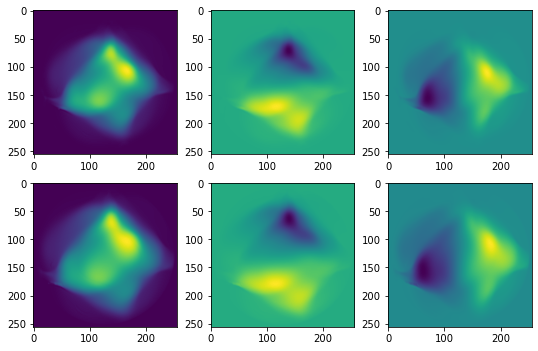

In [4]:
x, y = dataset[7]

fig = plt.figure(figsize=(9,9))

fig.add_subplot(3, 3, 1)
plt.imshow(torch.squeeze(x)[0])
fig.add_subplot(3, 3, 4)
plt.imshow(torch.squeeze(y)[0])
fig.add_subplot(3, 3, 2)
plt.imshow(torch.squeeze(x)[1])
fig.add_subplot(3, 3, 5)
plt.imshow(torch.squeeze(y)[1])
fig.add_subplot(3, 3, 3)
plt.imshow(torch.squeeze(x)[2])
fig.add_subplot(3, 3, 6)
plt.imshow(torch.squeeze(y)[2])

In [5]:
batch_size = 6

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)

# Обучим с батчнормами
u8916epl2

In [6]:
from model import Unet, DeepUnet
import torch.optim as optim

def unet_loss(output, target):
    return 0.5 * torch.sum(torch.sum(torch.abs(output - target), dim=(2,3)) / torch.sum(torch.abs(target), dim=(2,3)))


def l2_loss(output, target):
    return torch.sum(torch.sum((output - target) ** 2, dim=(2,3)))
    

model = Unet(hidden_size=64,in_channels=3,out_dim=3)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 1142.301852, Val loss: 128.548105
Average loss: 53.251344, Val loss: 45.067612
Average loss: 44.297909, Val loss: 65.583137
Average loss: 39.265991, Val loss: 60.436167
Average loss: 23.537896, Val loss: 16.145700
Average loss: 25.439806, Val loss: 15.322594
Average loss: 23.641035, Val loss: 17.314200
Average loss: 22.659644, Val loss: 15.514372
Average loss: 16.428602, Val loss: 5.405924
Average loss: 16.213556, Val loss: 7.580122
Average loss: 15.755268, Val loss: 31.548199
Average loss: 15.425086, Val loss: 6.535273
Average loss: 11.568002, Val loss: 3.104235
Average loss: 11.359233, Val loss: 3.142149
Average loss: 11.671280, Val loss: 11.725849
Average loss: 12.215663, Val loss: 2.335893


In [7]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

model.eval()
indices = list(range(20))
sampler = SubsetSampler(indices)
loader = torch.utils.data.DataLoader(dataset,
                                     sampler=sampler)

device=torch.device("cpu")
model.to(device)
t = iter(loader)
next(t)
#next(t)
#next(t)
x, y = next(t)
x = x.to(device)

In [8]:
%%time
model.eval()
prediction = model(x)

Wall time: 2.62 s


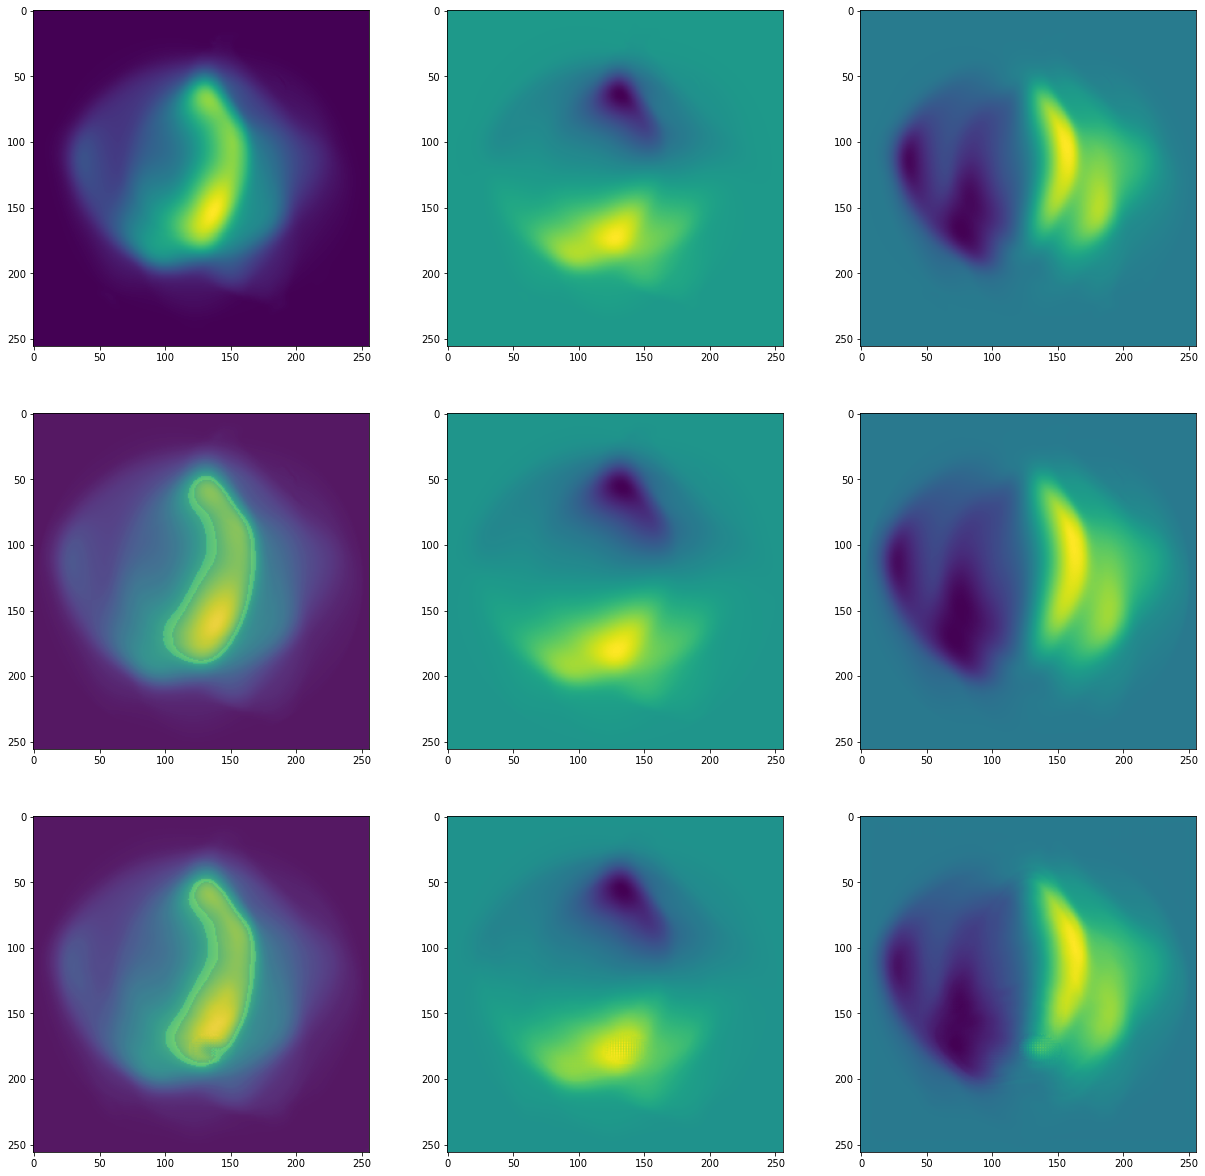

In [9]:
import matplotlib.pyplot as plt
EPS = 0.01
fig = plt.figure(figsize=(21,21))
  
prediction = prediction.detach().cpu()
fig.add_subplot(3, 3, 1)
plt.imshow(torch.squeeze(x)[0])
fig.add_subplot(3, 3, 2)
plt.imshow(torch.squeeze(x)[1])
fig.add_subplot(3, 3, 3)
plt.imshow(torch.squeeze(x)[2])
fig.add_subplot(3, 3, 4)
plt.imshow(torch.squeeze(y)[0],alpha=0.9)
plt.imshow(np.abs(torch.squeeze(y)[0] - 0.18) < EPS,alpha=0.1)
fig.add_subplot(3, 3, 5)
plt.imshow(torch.squeeze(y)[1])
fig.add_subplot(3, 3, 6)
plt.imshow(torch.squeeze(y)[2])
fig.add_subplot(3, 3, 7)
plt.imshow(torch.squeeze(prediction)[0], alpha=0.9)
plt.imshow(np.abs(torch.squeeze(prediction)[0] - 0.18) < EPS, alpha=0.1)
fig.add_subplot(3, 3, 8)
plt.imshow(torch.squeeze(prediction)[1])
fig.add_subplot(3, 3, 9)
plt.imshow(torch.squeeze(prediction)[2])

# То же самое, без батч норм

In [7]:
from model import Unet, DeepUnet
import torch.optim as optim

def unet_loss(output, target):
    return 0.5 * torch.sum(torch.sum(torch.abs(output - target), dim=(2,3)) / torch.sum(torch.abs(target), dim=(2,3)))


def l2_loss(output, target):
    return torch.sum(torch.sum((output - target) ** 2, dim=(2,3)))

model = Unet(hidden_size=64,in_channels=3,out_dim=3)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 76.705931, Val loss: 7.028130
Average loss: 2.833625, Val loss: 6.401955
Average loss: 2.552504, Val loss: 11.791276
Average loss: 2.103291, Val loss: 18.473583
Average loss: 0.653419, Val loss: 0.919812
Average loss: 0.856696, Val loss: 4.174323
Average loss: 0.927068, Val loss: 0.946666
Average loss: 1.242848, Val loss: 1.544714
Average loss: 0.308501, Val loss: 0.826028
Average loss: 0.358611, Val loss: 0.425460
Average loss: 0.370797, Val loss: 0.733504
Average loss: 0.316272, Val loss: 0.323230
Average loss: 0.153793, Val loss: 0.164699
Average loss: 0.164470, Val loss: 0.251269
Average loss: 0.170192, Val loss: 0.423451
Average loss: 0.164194, Val loss: 0.253926


In [17]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

model.eval()
indices = list(range(20))
sampler = SubsetSampler(indices)
loader = torch.utils.data.DataLoader(dataset,
                                     sampler=sampler)

device=torch.device("cpu")
model.to(device)
t = iter(loader)
next(t)
next(t)
next(t)
next(t)
x, y = next(t)
x = x.to(device)


In [18]:
%%time
model.eval()
prediction = model(x)

Wall time: 716 ms


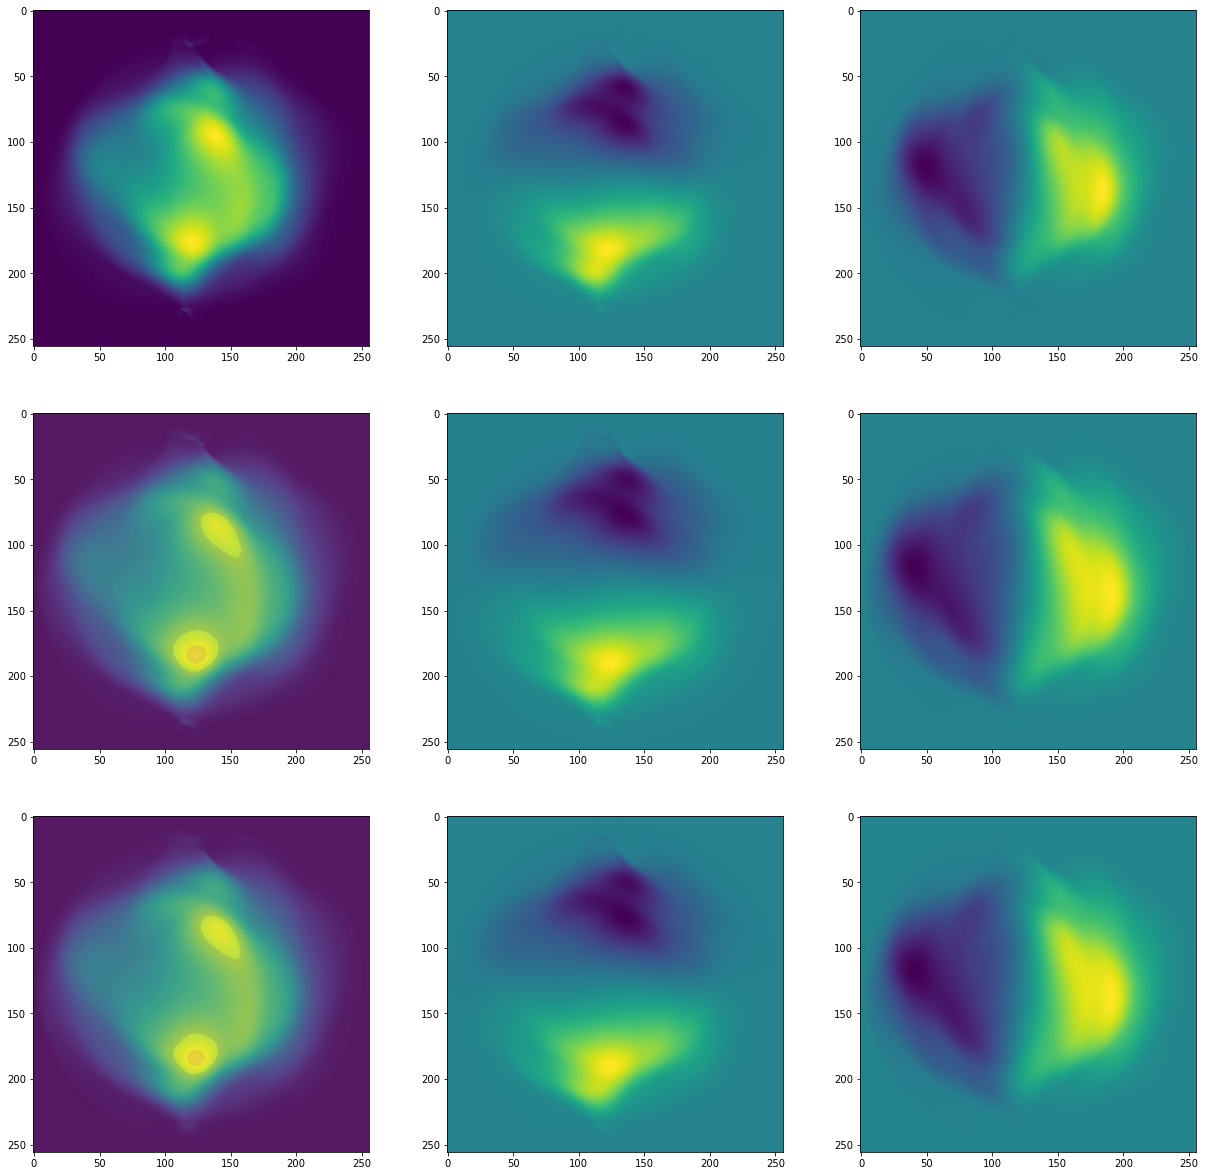

In [19]:
import matplotlib.pyplot as plt
EPS = 0.01
fig = plt.figure(figsize=(21,21))
  
prediction = prediction.detach().cpu()
fig.add_subplot(3, 3, 1)
plt.imshow(torch.squeeze(x)[0])
fig.add_subplot(3, 3, 2)
plt.imshow(torch.squeeze(x)[1])
fig.add_subplot(3, 3, 3)
plt.imshow(torch.squeeze(x)[2])
fig.add_subplot(3, 3, 4)
plt.imshow(torch.squeeze(y)[0],alpha=0.9)
plt.imshow(np.abs(torch.squeeze(y)[0] - 0.18) < EPS,alpha=0.1)
fig.add_subplot(3, 3, 5)
plt.imshow(torch.squeeze(y)[1])
fig.add_subplot(3, 3, 6)
plt.imshow(torch.squeeze(y)[2])
fig.add_subplot(3, 3, 7)
plt.imshow(torch.squeeze(prediction)[0], alpha=0.9)
plt.imshow(np.abs(torch.squeeze(prediction)[0] - 0.18) < EPS, alpha=0.1)
fig.add_subplot(3, 3, 8)
plt.imshow(torch.squeeze(prediction)[1])
fig.add_subplot(3, 3, 9)
plt.imshow(torch.squeeze(prediction)[2])

In [22]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=7, end_moment=8,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)
batch_size = 6

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=3, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 342.636686, Val loss: 28.684929
Average loss: 8.835473, Val loss: 12.759680
Average loss: 5.414183, Val loss: 3.792427
Average loss: 4.689140, Val loss: 2.654682
Average loss: 1.268649, Val loss: 13.145312
Average loss: 1.785169, Val loss: 6.457255
Average loss: 1.887722, Val loss: 4.738778
Average loss: 1.507058, Val loss: 1.511134
Average loss: 0.578292, Val loss: 0.624532
Average loss: 0.711215, Val loss: 0.916356
Average loss: 0.730399, Val loss: 1.162535
Average loss: 0.767505, Val loss: 0.609188
Average loss: 0.345388, Val loss: 0.619747
Average loss: 0.366458, Val loss: 3.755713
Average loss: 0.418791, Val loss: 0.562856
Average loss: 0.342540, Val loss: 0.740325


In [23]:
torch.save(model, '../models/du7816epl2_batchless.pth')
del model
torch.cuda.empty_cache()

In [24]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=6, end_moment=7,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)
batch_size = 6

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=3, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 1101.682753, Val loss: 32.422256
Average loss: 20.409098, Val loss: 26.990994
Average loss: 11.599429, Val loss: 12.532292
Average loss: 10.339711, Val loss: 10.876853
Average loss: 4.014421, Val loss: 4.502318
Average loss: 4.596525, Val loss: 26.074453
Average loss: 4.756045, Val loss: 12.413441
Average loss: 4.220956, Val loss: 7.696570
Average loss: 1.787998, Val loss: 3.545711
Average loss: 1.945832, Val loss: 18.533816
Average loss: 2.252159, Val loss: 1.325048
Average loss: 1.871229, Val loss: 3.350572
Average loss: 0.940005, Val loss: 0.973249
Average loss: 1.022131, Val loss: 1.432680
Average loss: 0.991725, Val loss: 1.070353
Average loss: 0.950589, Val loss: 3.580602


In [25]:
torch.save(model, '../models/du6716epl2_batchless.pth')
del model
torch.cuda.empty_cache()

In [26]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=5, end_moment=6,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)
batch_size = 6

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=3, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 529.462543, Val loss: 99.462533
Average loss: 22.389827, Val loss: 49.471381
Average loss: 17.286868, Val loss: 16.410688
Average loss: 14.363742, Val loss: 20.485979
Average loss: 5.216698, Val loss: 28.854150
Average loss: 5.628912, Val loss: 5.415339
Average loss: 6.329649, Val loss: 11.942214
Average loss: 4.693395, Val loss: 6.272587
Average loss: 2.112655, Val loss: 2.246076
Average loss: 2.513814, Val loss: 2.587046
Average loss: 2.394209, Val loss: 2.226346
Average loss: 2.359912, Val loss: 2.856842
Average loss: 1.230277, Val loss: 1.667044
Average loss: 1.269963, Val loss: 2.157832
Average loss: 1.221769, Val loss: 2.022289
Average loss: 1.189768, Val loss: 1.312541


In [27]:
torch.save(model, '../models/du5616epl2_batchless.pth')
del model
torch.cuda.empty_cache()

In [44]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=4, end_moment=5,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)
batch_size = 8

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=3, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 4429.264439, Val loss: 133.090398
Average loss: 96.335241, Val loss: 71.136648
Average loss: 66.336265, Val loss: 47.530636
Average loss: 54.554016, Val loss: 39.872212
Average loss: 23.805732, Val loss: 25.338007
Average loss: 24.677272, Val loss: 19.653999
Average loss: 24.300658, Val loss: 21.090095
Average loss: 22.308082, Val loss: 19.199688
Average loss: 11.376514, Val loss: 16.347948
Average loss: 11.621193, Val loss: 14.738386
Average loss: 12.260976, Val loss: 11.051369
Average loss: 11.019145, Val loss: 15.339250
Average loss: 7.245553, Val loss: 7.420734
Average loss: 7.578137, Val loss: 13.172674
Average loss: 7.010437, Val loss: 7.007526
Average loss: 6.779415, Val loss: 7.514609


In [45]:
torch.save(model, '../models/du4516epl2_batchless.pth')
del model
torch.cuda.empty_cache()

In [30]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=3, end_moment=4,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)
batch_size = 6

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=3, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 3781.399231, Val loss: 215.632259
Average loss: 190.943124, Val loss: 603.497344
Average loss: 137.792978, Val loss: 145.702129
Average loss: 105.776978, Val loss: 69.184882
Average loss: 38.620003, Val loss: 46.166115
Average loss: 37.284634, Val loss: 360.559816
Average loss: 41.808998, Val loss: 30.818963
Average loss: 43.002335, Val loss: 37.674459
Average loss: 17.500318, Val loss: 25.237224
Average loss: 19.287364, Val loss: 17.065827
Average loss: 18.315563, Val loss: 45.093266
Average loss: 16.991217, Val loss: 195.156304
Average loss: 11.778136, Val loss: 11.452798
Average loss: 10.780332, Val loss: 12.400147
Average loss: 10.838447, Val loss: 12.621964
Average loss: 9.422788, Val loss: 9.579675


In [31]:
torch.save(model, '../models/du3416epl2_batchless.pth')
del model
torch.cuda.empty_cache()

In [42]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=2, end_moment=3,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)
batch_size = 8

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=3, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 27753.844916, Val loss: 2051.047819
Average loss: 843.288307, Val loss: 489.161748
Average loss: 530.617572, Val loss: 368.797587
Average loss: 378.317556, Val loss: 246.272125
Average loss: 161.554927, Val loss: 165.589121
Average loss: 137.761104, Val loss: 140.641886
Average loss: 132.521645, Val loss: 139.842875
Average loss: 123.615993, Val loss: 85.062529
Average loss: 71.405846, Val loss: 71.860915
Average loss: 74.381916, Val loss: 63.102208
Average loss: 75.296230, Val loss: 58.551809
Average loss: 67.579222, Val loss: 76.099970
Average loss: 47.861846, Val loss: 48.127591
Average loss: 46.692743, Val loss: 51.426827
Average loss: 46.804534, Val loss: 43.542313
Average loss: 45.162953, Val loss: 57.331523


In [43]:
torch.save(model, '../models/du2316epl2_batchless.pth')
del model
torch.cuda.empty_cache()

In [34]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=1, end_moment=2,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)
batch_size = 6

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=3, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 73012.841759, Val loss: 6781.853119
Average loss: 2186.113848, Val loss: 1215.207897
Average loss: 680.568928, Val loss: 1020.932199
Average loss: 505.289065, Val loss: 929.769288
Average loss: 244.470482, Val loss: 588.596022
Average loss: 262.976369, Val loss: 556.653782
Average loss: 280.816931, Val loss: 161.322857
Average loss: 979.638908, Val loss: 379.305575
Average loss: 213.704427, Val loss: 202.096973
Average loss: 174.174914, Val loss: 176.807353
Average loss: 156.803036, Val loss: 139.452553
Average loss: 134.704484, Val loss: 183.201911
Average loss: 97.587739, Val loss: 98.568424
Average loss: 95.517943, Val loss: 250.886626
Average loss: 89.299950, Val loss: 84.565402
Average loss: 83.490268, Val loss: 97.208836


In [35]:
torch.save(model, '../models/du1216epl2_batchless.pth')
del model
torch.cuda.empty_cache()

In [38]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=0, end_moment=1,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=False)
batch_size = 8

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=1, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 185916.556541, Val loss: 4252.438942
Average loss: 5490.589490, Val loss: 1517.455393
Average loss: 3117.574258, Val loss: 1866.186807
Average loss: 2240.531436, Val loss: 927.939255
Average loss: 575.516961, Val loss: 505.007108
Average loss: 547.465880, Val loss: 384.807170
Average loss: 920.987602, Val loss: 705.391704
Average loss: 853.606289, Val loss: 240.185004
Average loss: 220.097543, Val loss: 258.409599
Average loss: 285.915217, Val loss: 240.141768
Average loss: 378.277972, Val loss: 227.676976
Average loss: 398.004626, Val loss: 3238.919375
Average loss: 167.306026, Val loss: 116.748694
Average loss: 118.789127, Val loss: 103.396945
Average loss: 156.725070, Val loss: 100.941316
Average loss: 152.928214, Val loss: 108.136136


In [39]:
torch.save(model, '../models/du0116epl2_batchless.pth')
del model
torch.cuda.empty_cache()

# Предсказание

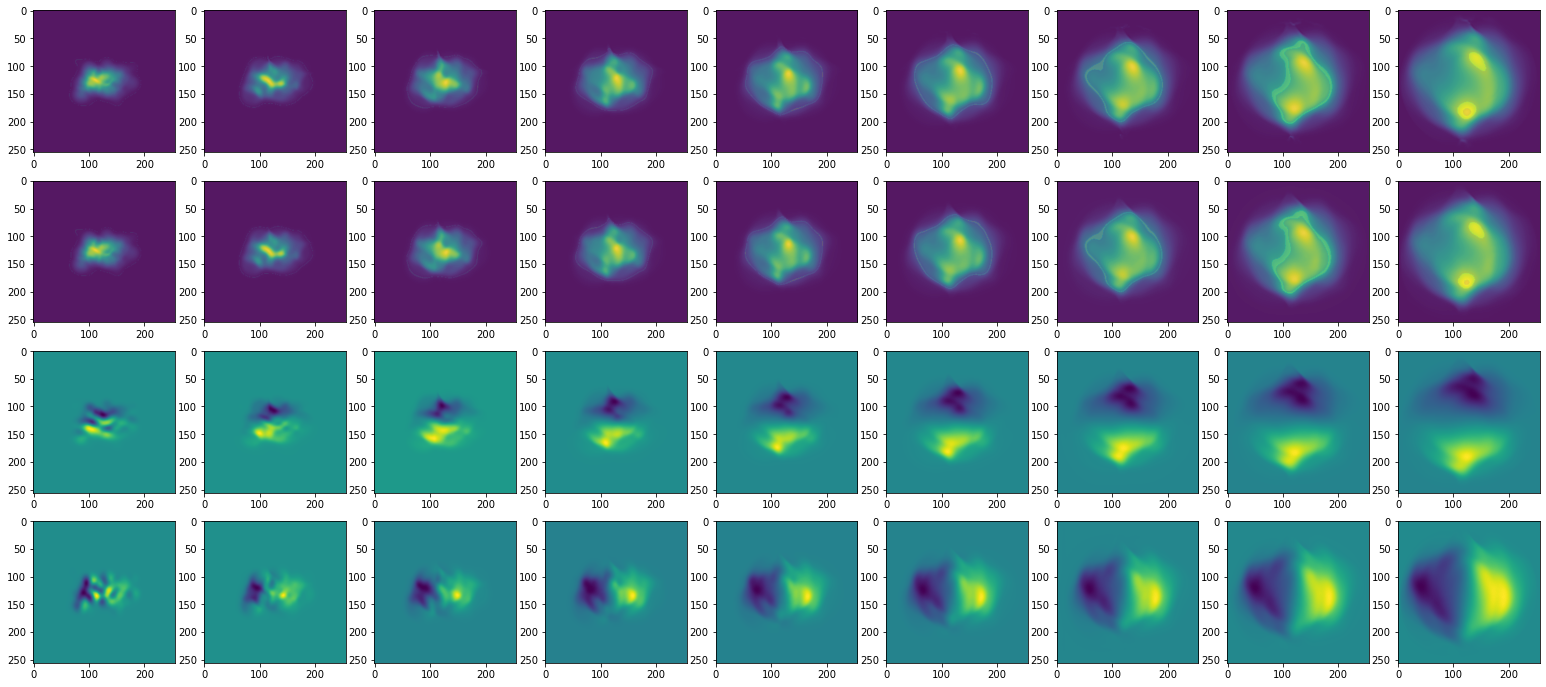

In [12]:
from torch.utils.data.sampler import Sampler

EPS = 0.01

class SubsetSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

train_folder = 'D:/CernDataset'
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=0, end_moment=1,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=False)
gd_dataset = datasets.CernDatasetFullEvo(train_folder, load_velocities=False, modified_velocities=False)

indices = list(range(20))
sampler = SubsetSampler(indices)
loader = torch.utils.data.DataLoader(dataset,
                                     sampler=sampler)

device=torch.device("cpu")
t = iter(loader)
next(t)
next(t)
next(t)
next(t)
x, y = next(t)
x = x.to(device)
_, y_gd = gd_dataset[4]

fig = plt.figure(figsize=(27,12))
for i in range(9):
    model = torch.load(f'../models/u{i}{i+1}16epl2_batchless.pth')
    model.to(device)
    model.eval()
    x = model(x)
    prediction = x.detach().cpu()
    fig.add_subplot(4, 9, i + 1)
    plt.imshow(y_gd[i], alpha=0.9)
    plt.imshow(np.abs(y_gd[i] - 0.18) < EPS,alpha=0.1)
    fig.add_subplot(4, 9, i + 10)
    plt.imshow(torch.squeeze(prediction)[0], alpha=0.9)
    plt.imshow(np.abs(torch.squeeze(prediction)[0] - 0.18) < EPS,alpha=0.1)
    fig.add_subplot(4, 9, i + 19)
    plt.imshow(torch.squeeze(prediction)[1])
    fig.add_subplot(4, 9, i + 28)
    plt.imshow(torch.squeeze(prediction)[2])

plt.savefig('../plots/consecutive_prediction_l2_4.png')   

# Попробуем натренировать модели лучше

In [6]:
from model import Unet, DeepUnet
import torch.optim as optim

def unet_loss(output, target):
    return 0.5 * torch.sum(torch.sum(torch.abs(output - target), dim=(2,3)) / torch.sum(torch.abs(target), dim=(2,3)))


def l2_loss(output, target):
    return torch.sum(torch.sum((output - target) ** 2, dim=(2,3)))

In [10]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=0, end_moment=1,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=False)
batch_size = 8

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=1, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = l2_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 155118.358578, Val loss: 2299.168707
Average loss: 2761.906166, Val loss: 1257.375096
Average loss: 2499.399429, Val loss: 697.390707
Average loss: 1198.981232, Val loss: 392.065816
Average loss: 338.908421, Val loss: 585.146289
Average loss: 671.047434, Val loss: 4281.909387
Average loss: 945.381070, Val loss: 4685.209504
Average loss: 609.278058, Val loss: 373.741663
Average loss: 164.362641, Val loss: 140.424392
Average loss: 217.862355, Val loss: 195.264741
Average loss: 313.452444, Val loss: 140.769540
Average loss: 270.570548, Val loss: 108.549363
Average loss: 93.293315, Val loss: 85.917471
Average loss: 149.148018, Val loss: 105.561291
Average loss: 102.698318, Val loss: 87.292894
Average loss: 148.103372, Val loss: 79.163154


In [15]:
torch.save(model, 'tt.pth')

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.00003, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 4, scheduler)

Average loss: 78.180136, Val loss: 60.242781
Average loss: 59.664950, Val loss: 71.433257
Average loss: 57.946022, Val loss: 48.764399
Average loss: 50.817154, Val loss: 53.690821


In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 4, scheduler)

Average loss: 44.866592, Val loss: 42.898651
Average loss: 42.650050, Val loss: 49.067744
Average loss: 40.599913, Val loss: 41.529727
Average loss: 39.136996, Val loss: 39.289404


In [16]:
loss = unet_loss
compute_loss(model, val_loader)

0.0961831577667376

In [18]:
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=0, end_moment=1,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=False)
batch_size = 8

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)


model = Unet(in_channels=1, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = unet_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 1.706544, Val loss: 1.921513
Average loss: 0.709787, Val loss: 0.975715
Average loss: 0.516687, Val loss: 0.551608
Average loss: 0.426225, Val loss: 0.546591
Average loss: 0.211144, Val loss: 0.285123
Average loss: 0.216489, Val loss: 0.390790
Average loss: 0.217144, Val loss: 0.110413
Average loss: 0.219284, Val loss: 0.120777
Average loss: 0.082657, Val loss: 0.073199
Average loss: 0.089413, Val loss: 0.081543
Average loss: 0.111997, Val loss: 0.081835
Average loss: 0.124928, Val loss: 0.199871
Average loss: 0.058418, Val loss: 0.056831
Average loss: 0.058075, Val loss: 0.055706
Average loss: 0.058421, Val loss: 0.055080
Average loss: 0.067022, Val loss: 0.064057


In [19]:
loss = l2_loss
compute_loss(model, val_loader)

37.97066167273172

In [21]:
loss = unet_loss

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.00003, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 4, scheduler)

Average loss: 0.045346, Val loss: 0.043684
Average loss: 0.043351, Val loss: 0.042832
Average loss: 0.042233, Val loss: 0.042866
Average loss: 0.041063, Val loss: 0.040207


In [23]:
loss = l2_loss
compute_loss(model, val_loader)

18.107201679741465

In [28]:
torch.save(model, 'tt_ul.pth')

In [25]:
loss = unet_loss

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 4, scheduler)

Average loss: 0.039230, Val loss: 0.039315
Average loss: 0.038656, Val loss: 0.039001
Average loss: 0.038201, Val loss: 0.038530
Average loss: 0.037748, Val loss: 0.037834


In [27]:
loss = l2_loss
compute_loss(model, val_loader)

16.626088519212676

# Попробуем дообучать остальные

In [3]:
train_folder = 'D:/CernDataset'
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=8, end_moment=9,
                                                predict_type=-1, modified_velocities=True,
                                                use_init_velocities=True)

In [4]:
batch_size = 8

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [46]:
loss = l2_loss
compute_loss(model, val_loader)

0.3381550091432362

In [47]:
loss = unet_loss
compute_loss(model, val_loader)

0.14412750932501583

In [5]:
from model import Unet, DeepUnet
import torch.optim as optim

def unet_loss(output, target):
    return 0.5 * torch.sum(torch.sum(torch.abs(output - target), dim=(2,3)) / torch.sum(torch.abs(target), dim=(2,3)))


def l2_loss(output, target):
    return torch.sum(torch.sum((output - target) ** 2, dim=(2,3)))

In [6]:
model = Unet(in_channels=3, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = unet_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 3.564315, Val loss: 0.779727
Average loss: 0.797887, Val loss: 0.608077
Average loss: 0.582967, Val loss: 0.436387
Average loss: 0.516059, Val loss: 0.454112
Average loss: 0.275948, Val loss: 0.341155
Average loss: 0.278919, Val loss: 0.416621
Average loss: 0.267579, Val loss: 0.249081
Average loss: 0.268139, Val loss: 0.286495
Average loss: 0.142290, Val loss: 0.160928
Average loss: 0.165329, Val loss: 0.168374
Average loss: 0.140112, Val loss: 0.113629
Average loss: 0.147336, Val loss: 0.163467
Average loss: 0.093620, Val loss: 0.093165
Average loss: 0.094120, Val loss: 0.160500
Average loss: 0.098165, Val loss: 0.085469
Average loss: 0.091722, Val loss: 0.082460


In [15]:
torch.save(model, '../models/u89ul.pth')

In [7]:
loss = l2_loss
compute_loss(model, val_loader)

0.1682691058098543

In [9]:
loss = unet_loss

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.00003, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 4, scheduler)

Average loss: 0.070232, Val loss: 0.069875
Average loss: 0.067565, Val loss: 0.067541
Average loss: 0.065884, Val loss: 0.064693
Average loss: 0.064179, Val loss: 0.066850


In [12]:
loss = l2_loss
compute_loss(model, val_loader)

0.13629736473284115

In [13]:
loss = unet_loss
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 4, scheduler)

Average loss: 0.061025, Val loss: 0.060995
Average loss: 0.060227, Val loss: 0.060249
Average loss: 0.059564, Val loss: 0.059802
Average loss: 0.058911, Val loss: 0.058925


In [14]:
loss = l2_loss
compute_loss(model, val_loader)

0.12457542174109598

# Что, если использовать только Ed на вход

In [16]:
train_folder = 'D:/CernDataset'
dataset = datasets.CernDatasetOneStepVelocities(train_folder, start_moment=8, end_moment=9,
                                                predict_type=-1, modified_velocities=True)

In [17]:
batch_size = 8

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
model = Unet(in_channels=1, out_dim=3, hidden_size=64)
device = torch.device("cuda:0")
model.to(device)

loss = unet_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 16, scheduler)

Average loss: 6.234397, Val loss: 3.434676
Average loss: 1.712907, Val loss: 2.059020
Average loss: 1.339676, Val loss: 1.529527
Average loss: 1.167748, Val loss: 1.302745
Average loss: 0.890408, Val loss: 0.891047
Average loss: 0.872559, Val loss: 0.893148
Average loss: 0.847128, Val loss: 0.799124
Average loss: 0.800179, Val loss: 0.758514
Average loss: 0.666316, Val loss: 0.706895
Average loss: 0.649455, Val loss: 0.637675
Average loss: 0.632862, Val loss: 0.640331
